In [1]:
!nvidia-smi

Mon Apr  1 19:08:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              N/A / ERR! |      4MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.get_num_threads()

4

In [5]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as data

### Zad 1

In [6]:
# LSTM

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
# read data from ariline-passangers.csv. 
df = pd.read_csv('airline-passengers.csv')
df["Passengers"] = df["Passengers"].apply(lambda x: float(x))

df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [8]:
# print df data types
df.dtypes

Month          object
Passengers    float64
dtype: object

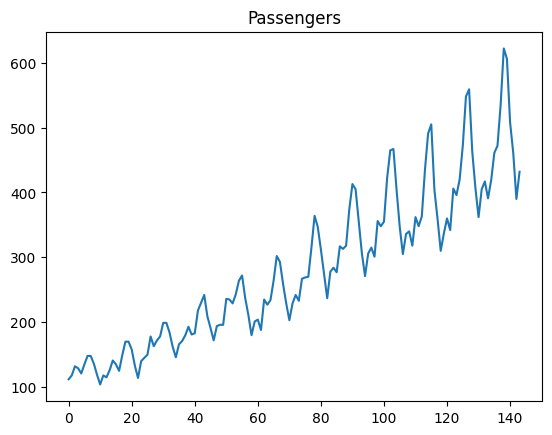

In [20]:
plt.plot(df['Passengers'])
plt.title('Passengers')
plt.show()

In [10]:
from torch.utils.data import Dataset

class FunctionDataset:
    class SequenceDs(Dataset):
        def __init__(self, X, y) -> None:
            super().__init__()
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
            return torch.tensor(self.X[index]).float(), torch.tensor(self.y[index]).float()

    def __init__(self, y_f, lookback, split_ratio=0.7):

        self.y_f = y_f
        self.total_samples = len(y_f)
        self.lookback = lookback

        X, y = self.generate_sequence(self.y_f, self.lookback)


        # split into train, validation and test set
        self.X = X[:int((self.total_samples - lookback) * split_ratio)]
        self.X_test = X[int((self.total_samples - lookback) *split_ratio):]

        self.y = y[:int((self.total_samples - lookback) * split_ratio)]
        self.y_test = y[int((self.total_samples - lookback) * split_ratio):]

        print(f'[Dataset]: total samples {self.total_samples}, sequence length {self.lookback}, total sequences {len(X)}, split ratio {split_ratio}, train {len(self.X)}, test {len(self.X_test)}')

    def generate_sequence(self, y, l):
        X_seq = []
        y_seq = []
        for i in range(len(y) - l):
            X_seq.append(y[i:i+l])
            y_seq.append(y[i+1:i+l+1])
        return np.array(X_seq), np.array(y_seq)

    def get_train_ds(self):
        return self.SequenceDs(self.X, self.y)

    def get_test_ds(self):
        return self.SequenceDs(self.X_test, self.y_test)

In [11]:
import time

def train(net, trainloader, testloader, criterion, optimizer, epochs, points_to_print=20):
    learning_start = time.time()

    net.train()

    print_every_n_batches = max(1, round(epochs * len(trainloader) / points_to_print))
    print('Print every %d batches' % print_every_n_batches)

    for epoch in range(epochs):
        # train
        for i, data in enumerate(trainloader, 0):
            net.train()

            X, y = data

            X = X.unsqueeze(2).cuda()
            y = y.unsqueeze(2).cuda()

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 3)
            optimizer.step()


            if (epoch * len(trainloader) + (i + 1)) % print_every_n_batches == print_every_n_batches - 1:

                # validate
                net.eval()

                train_loss = 0.0
                val_loss = 0.0

                with torch.no_grad():
                    for _, data in enumerate(trainloader, 0):
                        X, y = data

                        X = X.unsqueeze(2).cuda()
                        y = y.unsqueeze(2).cuda()

                        outputs = net(X)
                        loss = criterion(outputs, y)

                        train_loss += loss.item()

                    for _, data in enumerate(testloader, 0):
                        X, y = data

                        X = X.unsqueeze(2).cuda()
                        y = y.unsqueeze(2).cuda()

                        outputs = net(X)
                        loss = criterion(outputs, y)

                        val_loss += loss.item()


                print('[%4d, %4d] train RMSE: %.6g, test RMSE: %.6g' % (epoch + 1, i + 1, np.sqrt(train_loss / len(trainloader)), np.sqrt(val_loss / len(testloader))))


    learning_end = time.time()

    return learning_end - learning_start

In [12]:
batch_size = 8
epochs = 2000

In [13]:
ds = FunctionDataset(df['Passengers'], lookback=4)

train_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 144, sequence length 4, total sequences 140, split ratio 0.7, train 98, test 42


In [14]:
len(train_loader), len(test_loader)

(13, 6)

In [15]:
# model z zajec
net = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net, train_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 1300 batches
[100,    12] train RMSE: 192.161, test RMSE: 381.547
[200,    12] train RMSE: 144.799, test RMSE: 329.174
[300,    12] train RMSE: 110.963, test RMSE: 287.256
[400,    12] train RMSE: 88.982, test RMSE: 256.287
[500,    12] train RMSE: 73.3716, test RMSE: 230.79
[600,    12] train RMSE: 63.0055, test RMSE: 212.768
[700,    12] train RMSE: 55.2857, test RMSE: 198.898
[800,    12] train RMSE: 51.1795, test RMSE: 191.489
[900,    12] train RMSE: 48.3654, test RMSE: 186.268
[1000,    12] train RMSE: 44.1117, test RMSE: 177.222
[1100,    12] train RMSE: 39.6245, test RMSE: 166.045
[1200,    12] train RMSE: 35.5305, test RMSE: 154.486
[1300,    12] train RMSE: 32.1653, test RMSE: 144.14
[1400,    12] train RMSE: 29.5539, test RMSE: 135.614
[1500,    12] train RMSE: 28.1353, test RMSE: 129.166
[1600,    12] train RMSE: 26.5208, test RMSE: 122.85
[1700,    12] train RMSE: 25.7119, test RMSE: 116.529
[1800,    12] train RMSE: 24.7787, test RMSE: 112.135
[1900,    12] tr

In [16]:
def predict(net, loader, criterion):
    net.eval()

    preds = []
    loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            X, y = data

            X = X.unsqueeze(2).cuda()
            y = y.unsqueeze(2).cuda()

            outputs = net(X)
            loss += criterion(outputs, y).item()

            # append joined outpus
            preds = np.concatenate((preds, outputs[:, -1, :].cpu().numpy().flatten()))

    return loss / len(loader), preds

In [17]:
train_predict_loss, train_preds = predict(net, train_loader, criterion)
# test_predict_loss, test_preds = predict(net, test_loader, criterion)

In [18]:
def plot_model_results(actual, train_preds):
    plt.plot(actual, label='Actual')
    # plot train with red, test with green
    plt.plot(train_preds, label='Train predicted', color='red')
    # plt.plot(test_preds, label='Test predicted', color='green')

    plt.show()

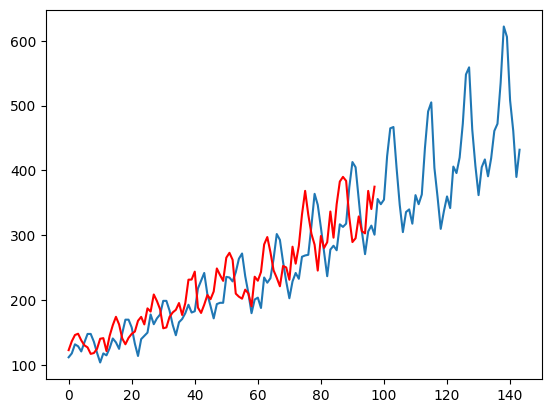

In [19]:
plot_model_results(df['Passengers'], train_preds)